<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/SoilCarbonModelling-emcee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy
from scipy.integrate import odeint
from scipy.stats.mstats import mquantiles
import emcee
sns.set()

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions


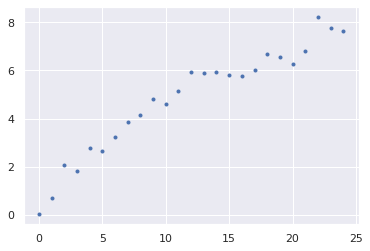

In [ ]:



data=pd.read_csv('CO2-2.csv')
data=data.values

totalC_t0=7.7 #not included in data
t0=0
Nt=25
ts=data[0:25,1]
eco2mean=data[0:25,2]
eco2sd=data[0:25,3]


ts=ts.astype(float)
eco2mean=eco2mean.astype(float)
eco2sd=eco2sd.astype(float)


plt.plot(eco2mean,'.')




In [ ]:
#Functions

def pplot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean( param )
    median = np.median( param )
    cred_min, cred_max = np.percentile( param, 2.5 ), np.percentile( param, 97.5 )

    # Plotting
    plt.subplot( 2, 1, 1 )
    plt.plot( param )
    plt.xlabel( 'samples' )
    plt.ylabel( param_name )
    plt.axhline( mean, color='r', lw=2, linestyle='--' )
    plt.axhline( median, color='c', lw=2, linestyle='--' )
    plt.axhline( cred_min, linestyle=':', color='k', alpha=0.2 )
    plt.axhline( cred_max, linestyle=':', color='k', alpha=0.2 )
    plt.title( 'Trace and Posterior Distribution for {}'.format( param_name ) )

    plt.subplot( 2, 1, 2 )
    plt.hist( param, 30, density=True );
    sns.kdeplot( param, shade=True )
    plt.xlabel( param_name )
    plt.ylabel( 'density' )
    plt.axvline( mean, color='r', lw=2, linestyle='--', label='mean' )
    plt.axvline( median, color='c', lw=2, linestyle='--', label='median' )
    plt.axvline( cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI' )
    plt.axvline( cred_max, linestyle=':', color='k', alpha=0.2 )

    plt.gcf().tight_layout()
    plt.legend()

def scODE( X,t, k1, k2, alpha21, alpha12):
    dC1dt= -k1*X[0]+ alpha12*k2*X[1]
    dC2dt= -k2*X[1]+ alpha21*k1*X[0]
    return np.array([ dC1dt, dC2dt  ])


def logPrior(theta):
    k1,k2,alpha21, alpha12, sigma, gamma=theta 
    if( all(theta>0) and gamma<1 ):
        a=np.sum(scipy.stats.halfnorm.logpdf([k1,k2,alpha21, alpha12]))
        b=scipy.stats.halfcauchy.logpdf(sigma)+scipy.stats.beta.logpdf(x=gamma, a=10, b=1)
        return a+b
    else:
        return -np.inf
    
    
def logL(theta):
    k1,k2,alpha21, alpha12, sigma, gamma=theta 
    X0=np.array( [ gamma*totalC_t0, (1-gamma)*totalC_t0 ] )
    Xt = odeint( scODE, X0, ts, args=( k1, k2, alpha21, alpha12),)
    C1t=Xt[:,0]
    C2t=Xt[:,1]
    eCO2hat= totalC_t0-( C1t+C2t)
    eCO2hat[eCO2hat<0]=0

    ll=np.sum(scipy.stats.norm.logpdf( x=eco2mean , loc=eCO2hat,scale=sigma))
    return ll


def logPosterior(theta):
    k1,k2,alpha21, alpha12, sigma, gamma=theta 
    if( all(theta>0) and gamma<1 ):
        temp=logPrior(theta)+logL(theta)
        return temp
    else:
        return -np.inf
    
    
 

def p0_emcee(nwalkers=1):
    p0=scipy.stats.uniform.rvs(0, 1, [nwalkers,6])    
    
    return p0



In [ ]:
import os

os.environ["OMP_NUM_THREADS"] = "4"

from multiprocessing import Pool
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

2 CPUs


In [ ]:
#emcee

nwalkers = 15
T=100000

bi=int(0.15*T)

ndim=6

with Pool() as pool:
    sampler =  emcee.EnsembleSampler(nwalkers, ndim, logPosterior, pool=pool )
    sampler.run_mcmc( p0_emcee(nwalkers) , T, progress=True)

  




100%|██████████| 100000/100000 [32:12<00:00, 51.76it/s]


In [ ]:

emcee_chains = sampler.get_chain()
samples=sampler.get_chain(flat=True)    

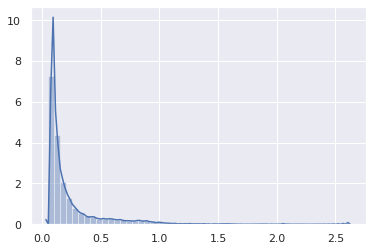

In [ ]:
sns.distplot(samples[:,0])

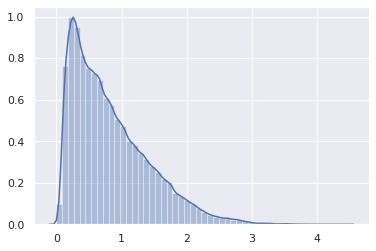

In [ ]:
sns.distplot(samples[:,1])

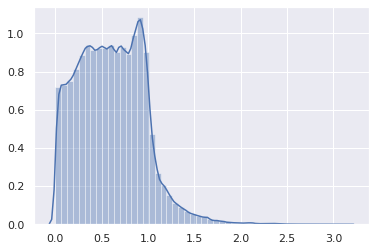

In [ ]:
sns.distplot(samples[:,2])

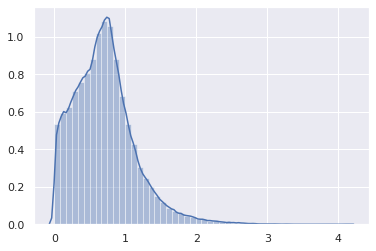

In [ ]:
sns.distplot(samples[:,3])

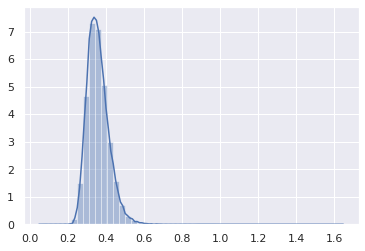

In [ ]:
sns.distplot(samples[:,4])

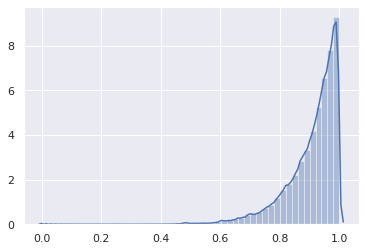

In [ ]:
sns.distplot(samples[:,5])

In [ ]:
k1=samples[bi:,0]
k2=samples[bi:,1]
alpha21=samples[bi:,2]
alpha12=samples[bi:,3]
sigma=samples[bi:,4]
gamma=samples[bi:,5]

In [ ]:
print('k1 ', np.median(k1)      )
print('k2 ', np.median(k2)      )
print('alpha21 ', np.median(alpha21)      )
print('alpha12 ', np.median(alpha12)      )
print('sigma ', np.median(sigma)      )
print('gamma ', np.median(gamma)      )

k1  0.12727379750545934
k2  0.6883045717426671
alpha21  0.589113180204859
alpha12  0.6727795431984966
sigma  0.35026912970088664
gamma  0.9355290027531235


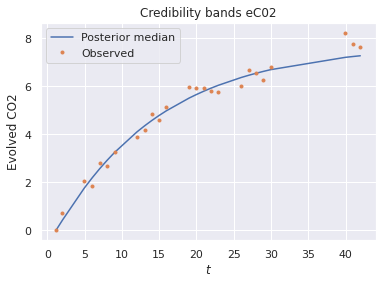

In [ ]:
#medians
mk1=np.median(k1)
mk2=np.median(k2)
malpha21=np.median(alpha21)
malpha12=np.median(alpha12)
msigma=np.median(sigma)
mgamma=np.median(gamma)

#quantiles




X0=np.array( [  mgamma*totalC_t0, (1-mgamma)*totalC_t0  ]  )
Xt= odeint( scODE, X0, ts, args=(  mk1,mk2,malpha21, malpha12, ))
C1t=Xt[:,0]
C2t=Xt[:,1]
eCO2hat= totalC_t0-( C1t+C2t)



plt.plot(ts, eCO2hat  , label='Posterior median' )
plt.plot(ts, eco2mean  , '.' ,label='Observed' )
#plt.fill_between( times, q1, q2 , alpha=0.6, color='red')
plt.xlabel( r'$t$' )
plt.ylabel( r'Evolved CO2' )
plt.title( 'Credibility bands eC02' )
plt.legend()
plt.savefig( 'eCO2-posteriormean.png', dpi=500  )
plt.show()



In [ ]:


def Analysis(x):
    mean=np.mean(x,0)
    median=np.median(x,0)
    var=np.var(x,0)

    ess=np.zeros( x.shape[1])
    for i in range( x.shape[1] ):
      ess[i]=tfp.mcmc.effective_sample_size(  x[:,i] , filter_beyond_positive_pairs=True)
    
    mess=np.min(ess)

    summary= {
        "Mean": mean,
        "Median":median,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        "mess":mess, #min ess

        }
    return summary

In [ ]:
AnalysisSamples=Analysis(samples)


In [ ]:
print(AnalysisSamples['ess'])

[ 343091.80115993 1381655.84011225 1319959.98978117 1372744.52379222
    2593.21289329    9341.44842374]


In [ ]:
 sampler.get_autocorr_time(tol=0)

array([4502.14296121, 1374.33248122, 1707.00965522, 1096.22609617,
        839.78804574, 1245.88632178])